# Sea Ice Extent Timeseries
## **SODA**

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.07914ad8319748c888a7bcb807f089e5 Dashboard: /services/dask-gateway/clusters/staging.07914ad8319748c888a7bcb807f089e5/status,Cluster Workers: 20 Cores: 40 Memory: 160.00 GiB


In [127]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [4]:
path = "s3://Pangeo/pangeo-forge/soda342/5day_ice.zarr"
mapper = fsspec.get_mapper(
    path, anon=True, client_kwargs={'endpoint_url': 'https://ncsa.osn.xsede.org'},
)
ds = xr.open_zarr(mapper, consolidated=True)

In [5]:
ds

<xarray.Dataset>
Dimensions:      (ct: 5, nv: 2, time: 2117, xb: 1441, xt: 1440, xv: 1440, yb: 1071, yt: 1070, yv: 1070)
Coordinates:
  * ct           (ct) float64 0.0 0.1 0.3 0.7 1.1
  * nv           (nv) float64 1.0 2.0
  * time         (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
  * xb           (xb) float64 -280.0 -279.8 -279.5 -279.3 ... 79.53 79.77 80.0
  * xt           (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * xv           (xv) float64 -279.8 -279.5 -279.3 -279.1 ... 79.53 79.77 80.0
  * yb           (yb) float64 -80.07 -79.97 -79.86 -79.76 ... 78.84 78.85 78.85
  * yt           (yt) float64 -80.02 -79.92 -79.81 -79.7 ... 78.84 78.84 78.85
  * yv           (yv) float64 -79.97 -79.86 -79.76 -79.65 ... 78.84 78.85 78.85
Data variables:
    average_DT   (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    cn           (time, ct, yt, xt) float32 dask.array<chunksize=(1, 5, 1070, 1440), meta=np.ndarray>
    hi           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hs           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    ix_trans     (time, yt, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    iy_trans     (time, yv, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    mi           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    time_bounds  (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    ui           (time, yv, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    vi           (time, yv, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ice_or_1992_01_05.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

In [6]:
ds.cn

,Array,Chunk
Bytes,60.76 GiB,29.39 MiB
Shape,"(2117, 5, 1070, 1440)","(1, 5, 1070, 1440)"
Count,2118 Tasks,2117 Chunks
Type,float32,numpy.ndarray


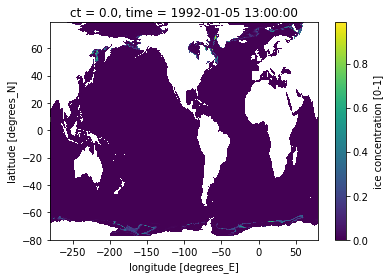

In [7]:
ds.cn[0,0].plot();

In [8]:
#WG boundaries (80˚S, 50˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 256 #-49.97878644
left_lon =  867 #-65.44282571
right_lon = 1228 #30.0427

#lower_lat_u = 0 #-79.96821565
#upper_lat_u = 169 #-61.96096874 python is right exclusive on isel so will have -62.0 in array
#left_lon_u = 859 #-65.0
#right_lon_u = 1240 #30.25 python is right exclusive on isel so will have 30.0˚E

In [9]:
#set the boundaries
#lat_range = dict(yt=slice(lower_lat, upper_lat), yv=slice(lower_lat_u, upper_lat_u))
#lon_range = dict(xt=slice(left_lon, right_lon), xv=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt=slice(left_lon, right_lon))

#lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
#lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [10]:
ice = ds.cn.isel(**lat_range_no_u, **lon_range_no_u)
#ds_wg = ds.isel(**lat_range, **lon_range)

In [11]:
ice

,Array,Chunk
Bytes,3.64 GiB,1.76 MiB
Shape,"(2117, 5, 256, 361)","(1, 5, 256, 361)"
Count,4235 Tasks,2117 Chunks
Type,float32,numpy.ndarray


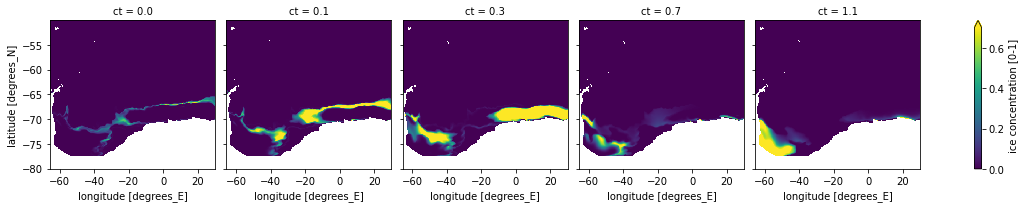

In [12]:
ice.isel(time=0,ct=[0,1,2,3,4]).plot(robust=True, col='ct');

In [13]:
ice.ct[2]

<xarray.DataArray 'ct' ()>
array(0.3)
Coordinates:
    ct       float64 0.3
Attributes:
    cartesian_axis:  Z
    long_name:       thickness
    units:           meters

In [14]:
#999 is ocean, 111 is land
mask = ice.where(ice == ice.notnull(), 999).where(ice < 999, 111)

In [15]:
mask

,Array,Chunk
Bytes,3.64 GiB,1.76 MiB
Shape,"(2117, 5, 256, 361)","(1, 5, 256, 361)"
Count,16937 Tasks,2117 Chunks
Type,float32,numpy.ndarray


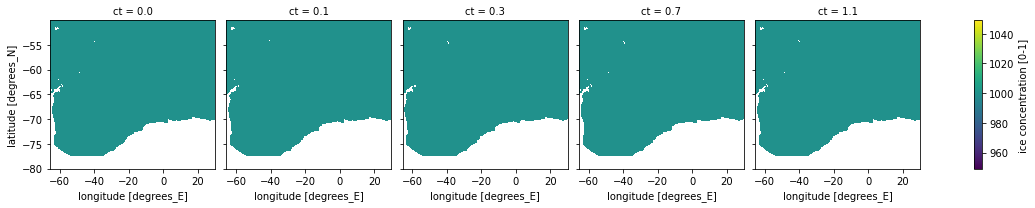

In [16]:
mask.where(mask == 999).isel(time=0,ct=[0,1,2,3,4]).plot(robust=True, col='ct');

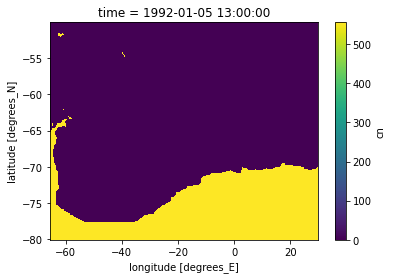

In [17]:
mask.where(mask == 111).sum('ct')[0].plot()

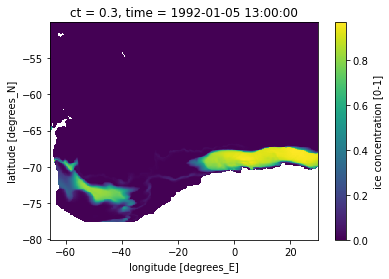

In [18]:
ice.isel(time=0, ct=2).plot()

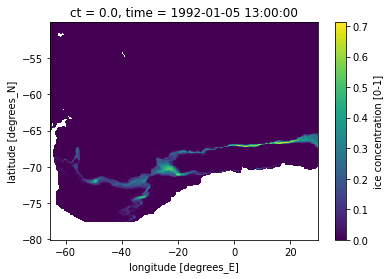

In [19]:
ice[0,0].plot()

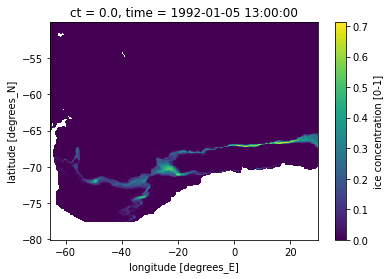

In [20]:
ice.where(mask == 999)[0,0].plot()

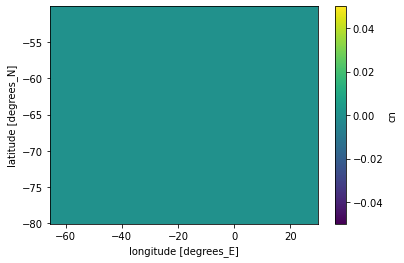

In [21]:
mask.where(mask == 111).sum('ct').std(dim='time').plot()

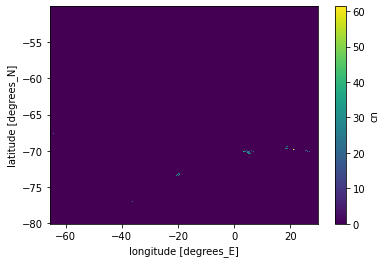

In [22]:
mask.where(mask == 999).sum('ct').std(dim='time').plot()

In [23]:
land = mask.where(mask == 999).sum('ct')[0]

In [24]:
land

<xarray.DataArray 'cn' (yt: 256, xt: 361)>
dask.array<getitem, shape=(256, 361), dtype=float32, chunksize=(256, 361), chunktype=numpy.ndarray>
Coordinates:
    time     object 1992-01-05 13:00:00
  * xt       (xt) float64 -65.44 -65.21 -64.97 -64.73 ... 29.06 29.31 29.55 29.8
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -50.46 -50.3 -50.14

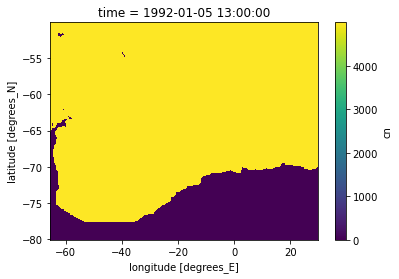

In [25]:
land.plot()

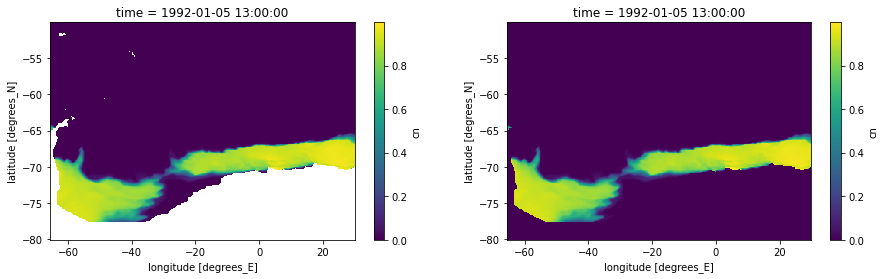

In [26]:
#values are slightly different with the mask. More yellow in plot without mask
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))

ice.sum('ct')[0].where(land).plot(ax=ax0)
ice.sum('ct')[0].plot(ax=ax1);

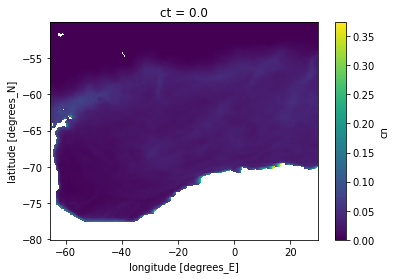

In [27]:
ice.mean(dim='time')[0].plot()

In [28]:
ice

,Array,Chunk
Bytes,3.64 GiB,1.76 MiB
Shape,"(2117, 5, 256, 361)","(1, 5, 256, 361)"
Count,4235 Tasks,2117 Chunks
Type,float32,numpy.ndarray


In [29]:
import xgcm

grid = xgcm.Grid(ice, coords={'X': {'center': 'xt', 'left': 'xb'}, 
                              'Y': {'center': 'yt', 'left': 'yb'},
                              'T': {'center': 'time'}},
                      periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt --> left
  * left     xb --> center
Y Axis (not periodic, boundary=None):
  * center   yt --> left
  * left     yb --> center
T Axis (not periodic, boundary=None):
  * center   time

In [30]:
import xgcm

grid_ds = xgcm.Grid(ds, coords={'X': {'center': 'xt', 'left': 'xv'}, 
                              'Y': {'center': 'yt', 'left': 'yv'},
                              'T': {'center': 'time'}},
                      periodic=['X'])
grid_ds

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt --> left
  * left     xv --> center
Y Axis (not periodic, boundary=None):
  * center   yt --> left
  * left     yv --> center
T Axis (not periodic, boundary=None):
  * center   time

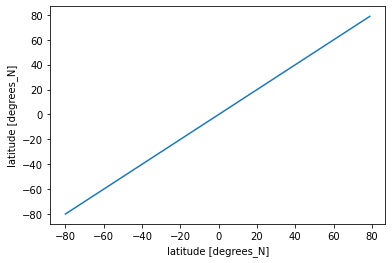

In [31]:
ds.yt.plot()

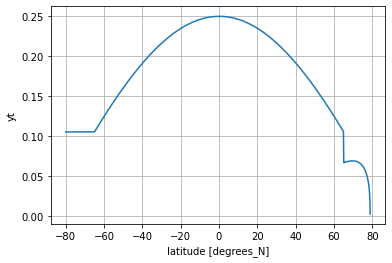

In [32]:
ds.yt.diff('yt').plot()
plt.grid()

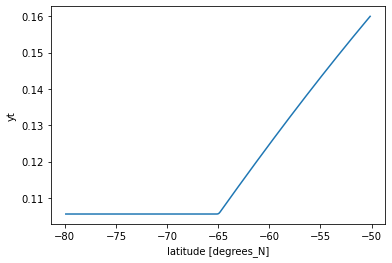

In [33]:
ice.yt.diff('yt').plot()

In [34]:
-80.021015 - -79.915416

-0.10559900000001221

In [35]:
78.843885 - 78.846942

-0.003056999999998311

In [36]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360

#converting lat from degrees to meters
delta_lat = grid_ds.diff(ds.yt, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid_ds.diff(ds.xt, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds.yt))

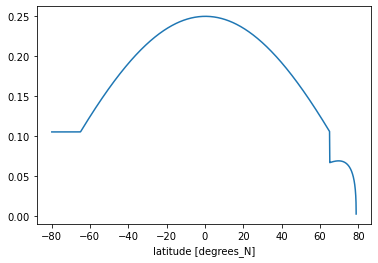

In [37]:
delta_lat.plot()

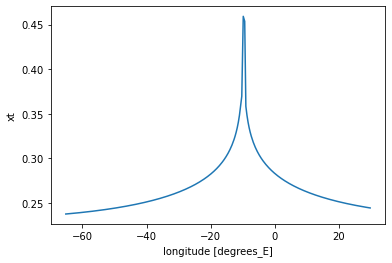

In [38]:
ice.xt.diff('xt').plot()

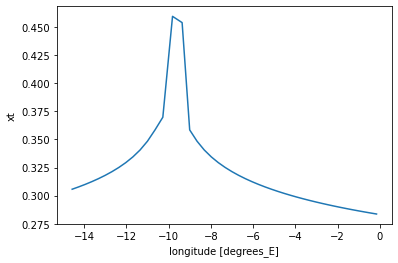

In [39]:
ice.xt.sel(xt=slice(-15,0)).diff('xt').plot()

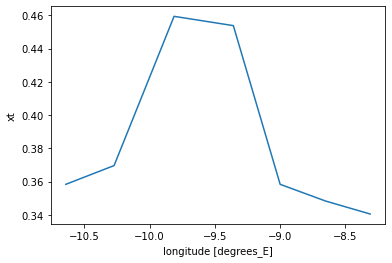

In [40]:
ice.xt.sel(xt=slice(-11,-8)).diff('xt').plot()

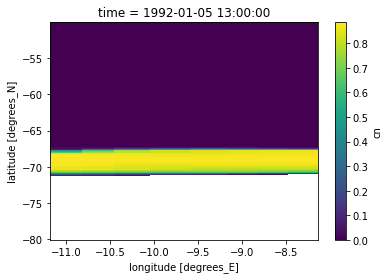

In [41]:
ice.sum('ct')[0].where(land).sel(xt=slice(-11,-8)).plot()

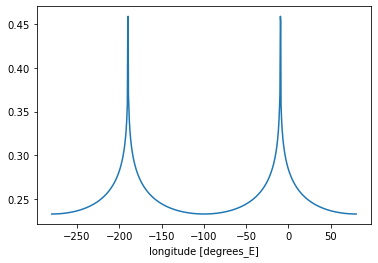

In [42]:
delta_lon.plot()

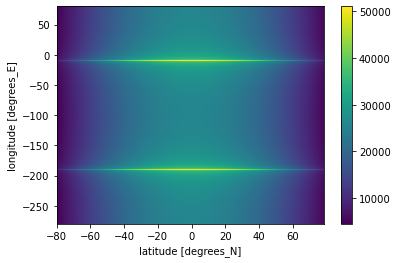

In [43]:
dx.plot()

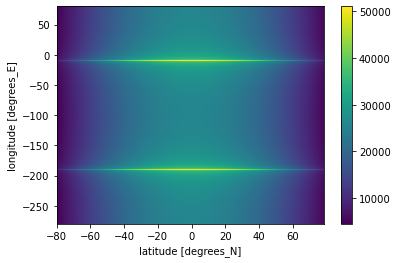

In [44]:
dx.plot()

In [45]:
dy

<xarray.DataArray (yv: 1070)>
array([           nan, 11742.02738041, 11742.02738041, ...,
         846.24200443,   611.37980187,   339.92483173])
Coordinates:
  * yv       (yv) float64 -79.97 -79.86 -79.76 -79.65 ... 78.84 78.85 78.85

In [46]:
dx

<xarray.DataArray (xv: 1440, yt: 1070)>
array([[4483.89737026, 4530.85802209, 4577.80328348, ..., 5008.91613819,
        5006.47998809, 5005.12547801],
       [4483.9013194 , 4530.86201259, 4577.80731532, ..., 5008.92054973,
        5006.48439749, 5005.12988621],
       [4483.91316703, 4530.8739843 , 4577.81941107, ..., 5008.9337846 ,
        5006.49762592, 5005.14311106],
       ...,
       [4483.9329138 , 4530.89393788, 4577.8395714 , ..., 5008.95584351,
        5006.5196741 , 5005.16515328],
       [4483.91316703, 4530.87398431, 4577.81941108, ..., 5008.9337846 ,
        5006.49762592, 5005.14311107],
       [4483.9013194 , 4530.86201259, 4577.80731532, ..., 5008.92054973,
        5006.48439749, 5005.12988621]])
Coordinates:
  * xv       (xv) float64 -279.8 -279.5 -279.3 -279.1 ... 79.3 79.53 79.77 80.0
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... 78.83 78.84 78.84 78.85

In [47]:
dy_interp = grid_ds.interp(dy, 'Y', boundary='fill')
dx_interp = grid_ds.interp(dx, 'X')

In [48]:
dx_interp

<xarray.DataArray (xt: 1440, yt: 1070)>
array([[4483.89934483, 4530.86001734, 4577.8052994 , ..., 5008.91834396,
        5006.48219279, 5005.12768211],
       [4483.90724321, 4530.86799845, 4577.8133632 , ..., 5008.92716716,
        5006.4910117 , 5005.13649864],
       [4483.92304041, 4530.88396109, 4577.82949123, ..., 5008.94481405,
        5006.50865001, 5005.15413217],
       ...,
       [4483.92304042, 4530.88396109, 4577.82949124, ..., 5008.94481406,
        5006.50865001, 5005.15413218],
       [4483.90724322, 4530.86799845, 4577.8133632 , ..., 5008.92716717,
        5006.4910117 , 5005.13649864],
       [4483.89934483, 4530.86001734, 4577.8052994 , ..., 5008.91834396,
        5006.48219279, 5005.12768211]])
Coordinates:
  * xt       (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... 78.83 78.84 78.84 78.85

In [49]:
dy_wg = dy_interp.isel(**lat_range_no_u)
dx_wg = dx_interp.isel(**lat_range_no_u, **lon_range_no_u)

In [50]:
dx_wg.coords

Coordinates:
  * xt       (xt) float64 -65.44 -65.21 -64.97 -64.73 ... 29.06 29.31 29.55 29.8
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -50.46 -50.3 -50.14

In [51]:
ice.coords

Coordinates:
  * ct       (ct) float64 0.0 0.1 0.3 0.7 1.1
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
  * xt       (xt) float64 -65.44 -65.21 -64.97 -64.73 ... 29.06 29.31 29.55 29.8
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -50.46 -50.3 -50.14

In [52]:
dy_wg.coords

Coordinates:
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -50.46 -50.3 -50.14

In [53]:
weighted_ice = ice * dx_wg * dy_wg

In [54]:
msi = ice.sum('ct').mean(dim='time').load()
msi_weighted = weighted_ice.sum('ct').mean(dim='time').load()

In [55]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


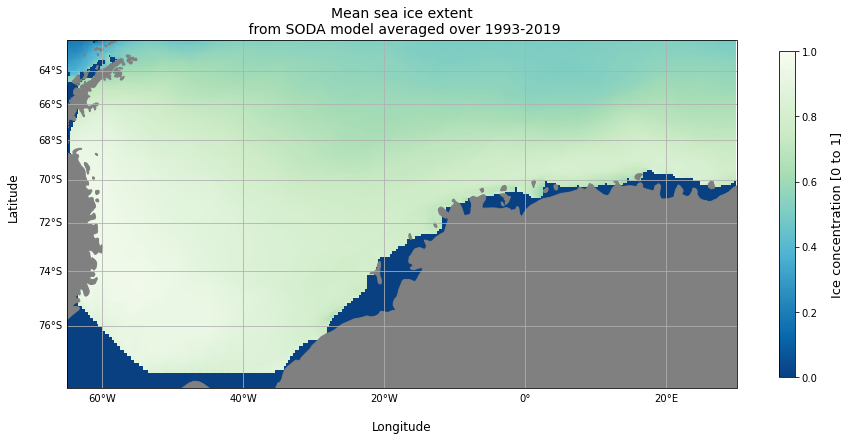

In [56]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ice.xt, ice.yt, msi, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Ice concentration [0 to 1]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Mean sea ice extent\n from SODA model averaged over 1993-2019', fontsize=14);

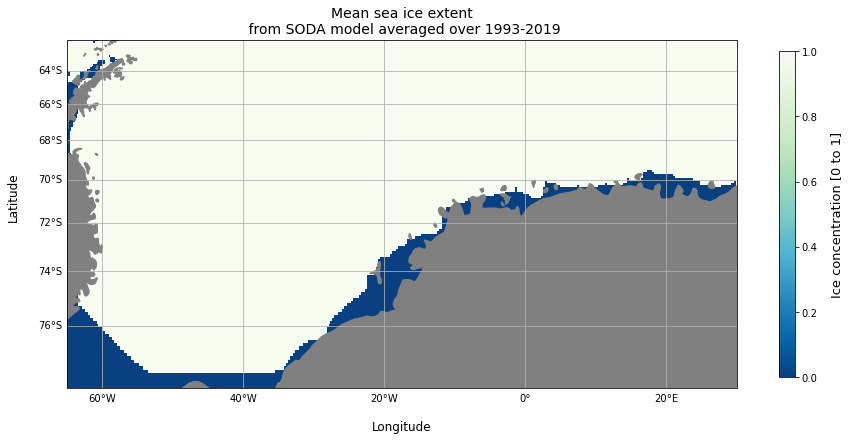

In [57]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ice.xt, ice.yt, msi_weighted, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Ice concentration [0 to 1]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Mean sea ice extent\n from SODA model averaged over 1993-2019', fontsize=14);

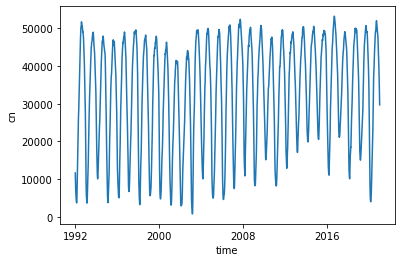

In [58]:
ice.sum(['ct', 'yt', 'xt']).plot();

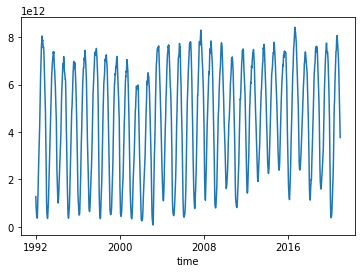

In [59]:
weighted_ice.sum(['ct', 'yt', 'xt']).plot();

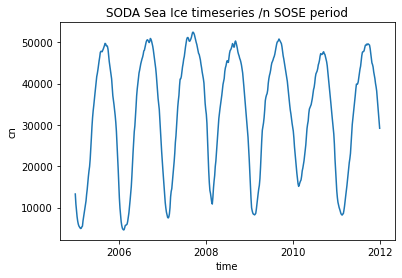

In [60]:
ice.sum(['ct', 'yt', 'xt']).sel(time=slice('2005', '2011')).plot()
plt.title('SODA Sea Ice timeseries /n SOSE period');

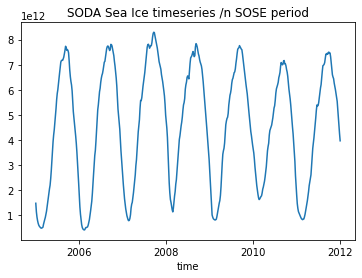

In [61]:
weighted_ice.sum(['ct', 'yt', 'xt']).sel(time=slice('2005', '2011')).plot()
plt.title('SODA Sea Ice timeseries /n SOSE period');

In [62]:
weighted_ice

,Array,Chunk
Bytes,7.29 GiB,3.53 MiB
Shape,"(2117, 5, 256, 361)","(1, 5, 256, 361)"
Count,8471 Tasks,2117 Chunks
Type,float64,numpy.ndarray


In [64]:
ice_anom = weighted_ice.groupby('time.month') - weighted_ice.groupby('time.month').mean()
ice_anom

,Array,Chunk
Bytes,7.29 GiB,3.53 MiB
Shape,"(2117, 5, 256, 361)","(1, 5, 256, 361)"
Count,19814 Tasks,2117 Chunks
Type,float64,numpy.ndarray


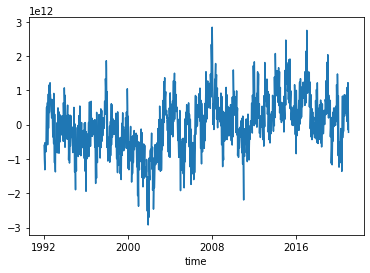

In [65]:
ice_anom.sum(['yt', 'xt', 'ct']).plot()

In [75]:
si_index = ice_anom.sum(['yt', 'xt', 'ct'])/ ice_anom.sum(['yt', 'xt', 'ct']).std(dim='time')
si_index

<xarray.DataArray (time: 2117)>
dask.array<truediv, shape=(2117,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 11 11 12 12 12 12 12

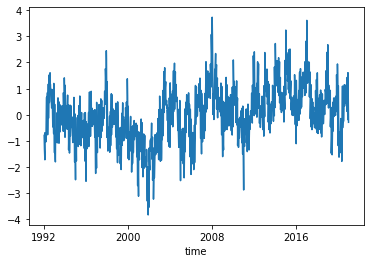

In [76]:
si_index.plot()

## SAM Index

In [37]:
url_ann = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/ann-seas-sam-57-07.csv'
ann_seas = pd.read_csv(url_ann, delim_whitespace=True, parse_dates=True, )
url_mo = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/mo-sam-57-07.csv'
mo = pd.read_csv(url_mo, delim_whitespace=True, parse_dates=True)

In [38]:
ann_seas.index = ann_seas.index.rename('time')
mo.index = mo.index.rename('time')

In [39]:
mo

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
time,,,,,,,,,,,,
1957-01-01,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958-01-01,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959-01-01,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960-01-01,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961-01-01,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018-01-01,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019-01-01,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78


In [40]:
#flattening dataframe by having next row go after the prev row, instead of col going after col
time = pd.date_range('1/1957', '1/2022', freq='M')
vector = np.array(mo.iloc[0])
for i in range(1,65):
    new_vec = np.array(mo.iloc[i])
    vector = np.append(vector,new_vec)

In [41]:
mo_xr = xr.DataArray(vector, coords=[time.rename('time')])

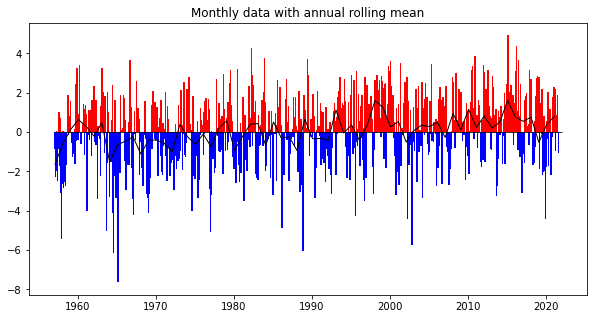

In [42]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.bar(time[np.where(mo_xr<0)], mo_xr.where(mo_xr < 0).dropna(dim='time'), color='b', width=70)
ax.bar(time[np.where(mo_xr>=0)], mo_xr.where(mo_xr >= 0).dropna(dim='time'), color='r', width=70)
ax.hlines(0, time[0], time[-1], colors='k', linewidth=0.8)
#mo_xr.rolling(time=12).mean().plot(color='k', linewidth=1)
plt.plot(time.values[np.arange(0, 780, 12)], mo_xr.groupby('time.year').mean().values, color='k', linewidth=1)
#mo_xr.groupby('time.year').mean().plot(color='k', linewidth=1)
plt.title('Monthly data with annual rolling mean');

## SAM & sea ice corr

In [43]:
ice.sum(['ct', 'yt', 'xt'])

<xarray.DataArray 'cn' (time: 2117)>
dask.array<sum-aggregate, shape=(2117,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00

In [44]:
ice.sum(['ct', 'yt', 'xt']).groupby('time.year').mean()

<xarray.DataArray 'cn' (year: 29)>
dask.array<stack, shape=(29,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1992 1993 1994 1995 1996 ... 2016 2017 2018 2019 2020

In [45]:
ann_seas.ANN.loc['1992':'2020']

time
1992-01-01   -0.96
1993-01-01    3.28
1994-01-01   -0.29
1995-01-01    1.19
1996-01-01   -1.04
1997-01-01    1.16
1998-01-01    4.46
1999-01-01    3.67
2000-01-01    0.26
2001-01-01    1.57
2002-01-01   -1.32
2003-01-01    0.35
2004-01-01    1.17
2005-01-01    0.30
2006-01-01    1.51
2007-01-01   -0.77
2008-01-01    2.28
2009-01-01    0.22
2010-01-01    3.28
2011-01-01    0.79
2012-01-01    2.11
2013-01-01    0.30
2014-01-01    1.31
2015-01-01    4.13
2016-01-01    1.67
2017-01-01    1.67
2018-01-01    1.96
2019-01-01   -1.50
2020-01-01    1.03
Name: ANN, dtype: float64

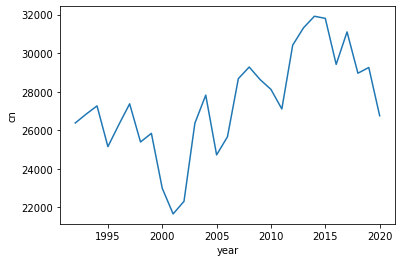

In [46]:
ice.sum(['ct', 'yt', 'xt']).groupby('time.year').mean().plot()

In [47]:
ann_xr = ann_seas.ANN.to_xarray()

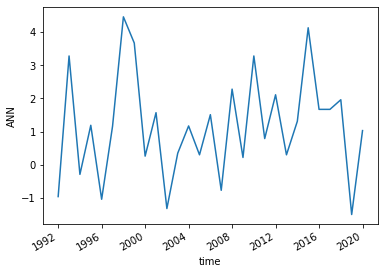

In [48]:
ann_xr.sel(time=slice('1992', '2020')).plot()

In [49]:
#changing SODA's SI timestamp to mo_xr timestamp
ice_ann = ice.sum(['ct', 'yt', 'xt']).groupby('time.year').mean().to_dataset().assign_coords(
                                time=ann_xr.time.sel(time=slice('1992', '2020')))#.drop('year')
ice_ann = ice_ann.cn.swap_dims({'year':'time'})
ice_ann

<xarray.DataArray 'cn' (time: 29)>
dask.array<stack, shape=(29,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    year     (time) int64 1992 1993 1994 1995 1996 ... 2016 2017 2018 2019 2020
Dimensions without coordinates: time

In [50]:
ann_xr.sel(time=slice('1992', '2020'))

<xarray.DataArray 'ANN' (time: 29)>
array([-0.96,  3.28, -0.29,  1.19, -1.04,  1.16,  4.46,  3.67,  0.26,
        1.57, -1.32,  0.35,  1.17,  0.3 ,  1.51, -0.77,  2.28,  0.22,
        3.28,  0.79,  2.11,  0.3 ,  1.31,  4.13,  1.67,  1.67,  1.96,
       -1.5 ,  1.03])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1993-01-01 ... 2020-01-01

In [52]:
corr_ice_ann = xr.corr(ice_ann, ann_xr.sel(time=slice('1992', '2020')), dim='time').values
corr_ice_ann

array(0.18884301)

In [54]:
ice.sum(['ct', 'xt', 'yt'])

<xarray.DataArray 'cn' (time: 2117)>
dask.array<sum-aggregate, shape=(2117,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00

In [55]:
corr_ann = xr.corr(ice.sum(['ct', 'xt', 'yt']), ann_xr.sel(time=slice('1992', '2020')), dim='time').values
corr_ann

array(nan)

In [57]:
corr_mo = xr.corr(ice.sum(['ct', 'xt', 'yt']), mo_xr.sel(time=slice('1992', '2020')), dim='time').values
corr_mo

array(nan)

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1125)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

## Saving Data

In [17]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [18]:
seaice_file = ice.to_dataset(name='seaice')

In [19]:
seaice_file

,Array,Chunk
Bytes,2.54 GiB,1.23 MiB
Shape,"(2117, 5, 169, 381)","(1, 5, 169, 381)"
Count,4235 Tasks,2117 Chunks
Type,float32,numpy.ndarray


In [20]:
#uploading wg region ice variable
gcsmap_seaice = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/seaice.zarr')
seaice_file.to_zarr(gcsmap_seaice, mode='w')